### Exemplo de simulação usando SIRC 2
via **lmfit.model**

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import lmfit
import matplotlib.pyplot as plt
import modelos_epidemiologicos as model
from datetime import datetime

print(datetime.now().isoformat(timespec='seconds'))


2025-05-22T14:01:07


In [2]:
# leitura dados
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/brainstorms/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
dfPA= dfE[dfE['state']=='PA' ]                                          #filtrar estado
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]            #filtrar cidade
print('arquivos lidos')
print(datetime.now().isoformat(timespec='seconds'))


arquivos lidos
2025-05-22T14:01:12


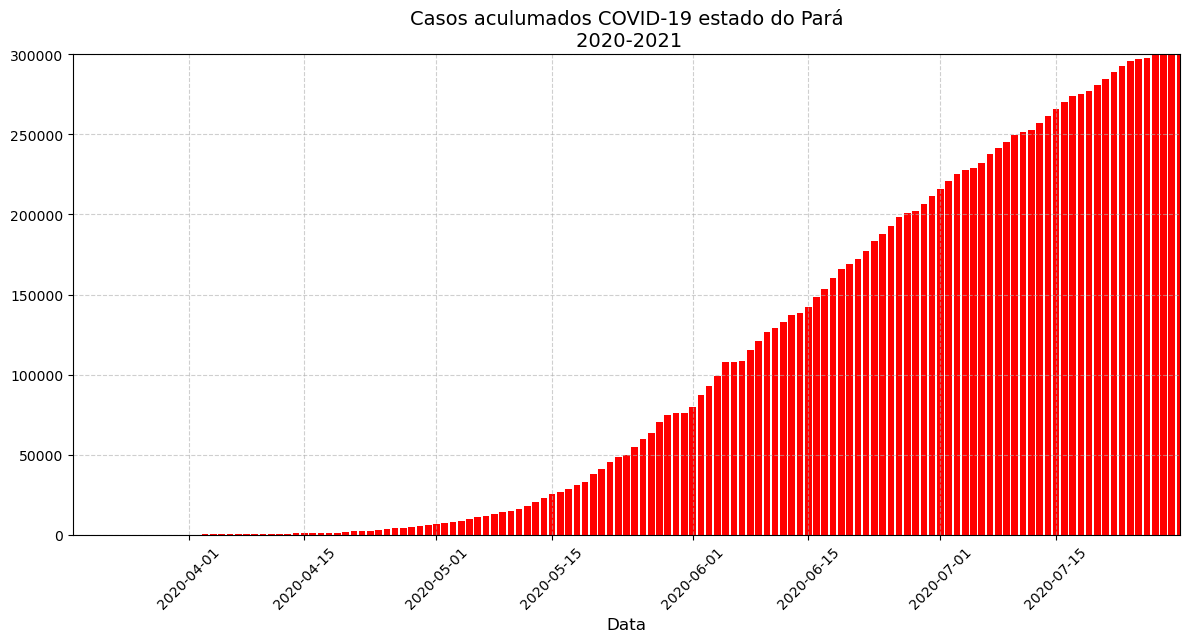

In [3]:
# Visualização
NCP=dfPA['new_confirmed'].values
NCB=dfbel['new_confirmed'].values

# casos acumulados
Cp=np.cumsum(NCP)
Cb=np.cumsum(NCB)

t_date=dfPA['date'].values

# periodo -01/02/2020 - 12/07/2020 (318)
yc=NCP[0:150]
y=Cp[0:150]
x=t_date[0:150] 

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='red', label='Dados originais')
plt.title('Casos aculumados COVID-19 estado do Pará\n 2020-2021', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.tight_layout()
plt.ylim([0,300000])
plt.xlim(pd.to_datetime(['2020-03-18', '2020-07-30'])) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45);  # Rotaciona as datas para melhor legibilidade

In [4]:
#funcoes
def solve_sirc(t,N,beta,gamma,I0):
    """Resolve o modelo SIRC e retorna casos acumulados."""
    R0 = 0
    C0 = I0
    S0 = N - I0 - R0
    y0 = [S0, I0, R0, C0]
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))
    return sol[:, 3]

print(datetime.now().isoformat(timespec='seconds'))

2025-05-22T14:01:18


In [13]:
c = y                  
t = np.arange(len(c))
I0=1.728745
N=700000
gamma_i=0.291505
beta_i=0.437257

R0 = 0
C0 = I0             # Casos acumulados iniciais = infectados iniciais
S0 = N  - I0 - R0
y0 = [S0, I0, R0, C0]


# Estimar chutes inicias e N
K,r,A = model.initial_SIRC(c)

I0 = K / (A + 1)         #infectados inicias
N = 2 * K                #populacao
gamma_i = 2 * r          #taxa de recuperacao
beta_i = 1.5 * gamma_i   #taxa de contagio

# ---------------------------
# PARÂMETROS INICIAIS
# ---------------------------
print('\n' + '='*40)
print('PARÂMETROS INICIAIS'.center(40))
print('='*40)
print(f'{"I0:":<10}{I0:>30.6f}')
print(f'{"N:":<10}{N:>30.6f}')
print(f'{"gamma_i:":<10}{gamma_i:>30.6f}')
print(f'{"beta_i:":<10}{beta_i:>30.6f}')
print(datetime.now().isoformat(timespec='seconds'))

# Configurar modelo
SIRC_model= lmfit.Model(solve_sirc,independent_vars=['t'])

# # Definição dos limites dos parametros
params = SIRC_model.make_params()
params['N'].set(value=N, vary=False)
params['beta'].set(value=beta_i, min=0.001, max=3.0)
params['gamma'].set(value=gamma_i, min=0.001, max=2.0)
params['I0'].set(value=I0, vary=False)
                # min=1, max=N)
result = SIRC_model.fit(y, params, t=t)
print(result.fit_report())



          PARÂMETROS INICIAIS           
I0:                             1.728745
N:                         708093.675215
gamma_i:                        0.291505
beta_i:                         0.437257
2025-04-28T11:15:23
[[Model]]
    Model(solve_sirc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 150
    # variables        = 2
    chi-square         = 7.0351e+10
    reduced chi-square = 4.7535e+08
    Akaike info crit   = 2998.91995
    Bayesian info crit = 3004.94122
    R-squared          = 0.96905196
[[Variables]]
    N:      708093.7 (fixed)
    beta:   0.51409090 +/- 0.00846905 (1.65%) (init = 0.4372568)
    gamma:  0.39552586 +/- 0.00806913 (2.04%) (init = 0.2915045)
    I0:     1.728745 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9973


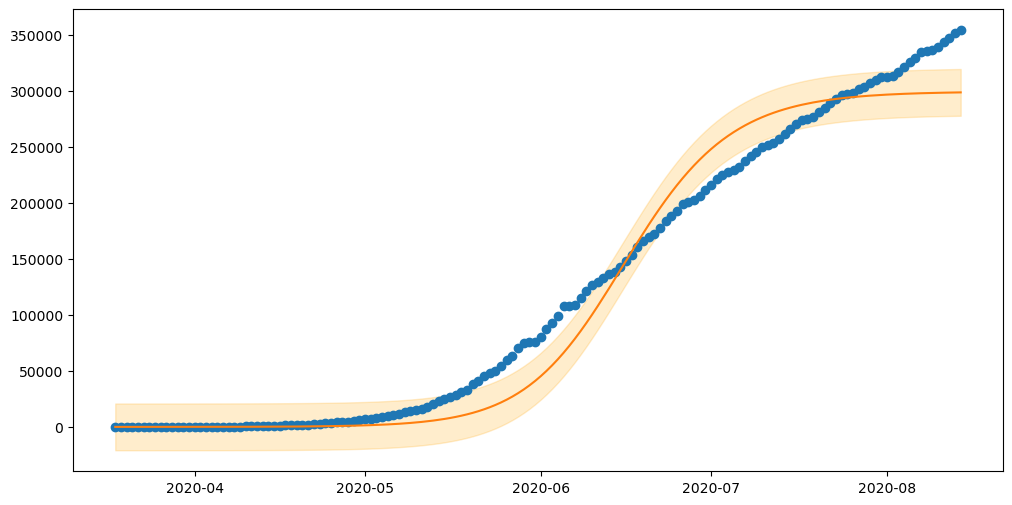

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x,y,'o',label='dados')
plt.plot(x,result.best_fit,label='melhor ajuste');  #melhor ajuste do modelo
plt.fill_between(
    x, 
    result.best_fit - result.residual.std(), 
    result.best_fit+ result.residual.std(), 
    color='Orange', alpha=0.2, label='Incerteza'
);